# Test analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import pandas as pd
import dask
# from wrf import to_np
# from mpl_toolkits.basemap impor                                                                                                                   t Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [2]:
# for quantreg
# from sklearn.linear_model import QuantileRegressor
from scipy import stats

In [3]:
from functions import ccplot, binning

In [4]:
# import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('tableau-colorblind10')
# sns.set_theme(style="ticks")
# plt.style.use(['science', 'notebook'])

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

In [6]:
fsize = 15
tsize = 18

tdir = 'in'

major = 5.0
minor = 3.0

# plt.style.use(style)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = major
plt.rcParams['ytick.minor.size'] = minor
plt.rcParams['axes.linewidth'] = 1.4
plt.rcParams['legend.handlelength'] = 0.5

In [7]:
# making a new colomap -> tmap

n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu_r
lower = cmap(np.linspace(0, diff, n))
lower2 = cmap2(np.linspace(0, diff, n))
white = np.ones((2, 4))
white2 = np.ones((2, 4))
upper = cmap(np.linspace(1-diff, 1, n))
upper2 = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, upper))
colors2 = np.vstack((lower2, white2, upper2))
tmap = m.colors.LinearSegmentedColormap.from_list('map_white', colors)
tmap2 = m.colors.LinearSegmentedColormap.from_list('map_white', colors2)

In [8]:
# client = Client(n_workers=30, threads_per_worker=1, memory_limit='60GB')

### Import data

In [9]:
mfdata_DIR1 = './data/GPM_lowres_data/*.nc'
gpm = xr.open_mfdataset(mfdata_DIR1, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_lowres_data/*.nc')

In [10]:
# gpm = gpm.unify_chunks()
# gpm.chunks

In [11]:
# gpm = gpm.chunk(dict(time = -1, lat = -1, lon = -1))

In [12]:
precip = gpm.precipCal.resample(time = '24H').sum() / 2

In [13]:
# precip = precip.chunk(dict(time = -1, lat = -1, lon = -1))

In [14]:
precip

<xarray.DataArray 'precipCal' (time: 7700, lat: 161, lon: 161)>
dask.array<truediv, shape=(7700, 161, 161), dtype=float32, chunksize=(1, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0

In [15]:
mfdata_DIR2 = './data/era_data/*.nc'
era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [16]:
era = era.sel(expver=1, drop=True)
era = era.transpose('time', 'latitude', 'longitude')
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})
era = era.rename({'longitude':'lon', 'latitude':'lat'})
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))
# era = era.chunk(dict(time=-1,lat=-1,lon=-1))
era

<xarray.Dataset>
Dimensions:  (lon: 161, lat: 161, time: 184800)
Coordinates:
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2021-06-30T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(5136, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [17]:
# era = era.chunk(dict(time = -1, lat = -1, lon = -1))

In [18]:
t2m = era.t2m.resample(time='24H').mean()
d2m = era.d2m.resample(time='24H').mean()
t2m

<xarray.DataArray 't2m' (time: 7700, lat: 161, lon: 161)>
dask.array<stack, shape=(7700, 161, 161), dtype=float32, chunksize=(1, 161, 161), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 1.0 0.75 0.5 0.25 0.0

In [19]:
precip = precip.chunk(dict(time=-1, lat=20, lon=20))
t2m = t2m.chunk(dict(time=-1, lat=20, lon=20))
d2m = d2m.chunk(dict(time=-1, lat=20, lon=20))

In [20]:
ds_comb = xr.merge([precip, t2m, d2m])
# ds_comb = precip.to_dataset()

In [21]:
ds_comb

<xarray.Dataset>
Dimensions:    (lat: 161, time: 7700, lon: 161)
Coordinates:
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(7700, 20, 20), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(7700, 1, 20), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(7700, 1, 20), meta=np.ndarray>

In [22]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [23]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [24]:
ds_comb_mon

<xarray.Dataset>
Dimensions:    (lat: 161, time: 2592, lon: 161)
Coordinates:
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2020-09-30
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(660, 20, 20), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(660, 1, 20), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(660, 1, 20), meta=np.ndarray>

In [25]:
ds_comb_mon = ds_comb_mon.chunk(dict(time=-1, lat=20, lon=20)).sortby('time.year')

In [30]:
# ds_comb_mon_loaded = ds_comb_mon.load()
# precipCal = ds_comn.precipCal.load()
# w1 = w1.load()
# t1 = t1.load()
# q1 = q1.load()
# pres = pres.load()

In [31]:
# precipCal

In [32]:
ds_comb_mon

<xarray.Dataset>
Dimensions:    (lat: 161, time: 2592, lon: 161)
Coordinates:
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2000-06-01 2000-06-02 ... 2021-06-30
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(2592, 20, 20), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(2592, 20, 20), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(2592, 20, 20), meta=np.ndarray>

### Single grid-point

#### getting the climatology

In [28]:
clim1 = xr.open_mfdataset('../../2308-35BD/imd_data/clim1/*.nc', chunks=dict(TIME=-1, LATITUDE=20, LONGITUDE=20), parallel=True)
clim2 = xr.open_mfdataset('../../2308-35BD/imd_data/clim2/*.nc', chunks=dict(TIME=-1, LATITUDE=20, LONGITUDE=20), parallel=True)
clim3 = xr.open_mfdataset('../../2308-35BD/imd_data/clim3/*.nc', chunks=dict(TIME=-1, LATITUDE=20, LONGITUDE=20), engine='netcdf4', combine='nested', concat_dim='TIME', parallel=True)

In [29]:
precip_clim1 = clim1.RAINFALL.chunk(dict(TIME=-1))
precip_clim2 = clim2.RAINFALL.chunk(dict(TIME=-1))
precip_clim3 = clim3.RAINFALL.chunk(dict(TIME=-1))

In [31]:
# precip_clim1_loaded = precip_clim1.load()
# precip_clim2_loaded = precip_clim2.load()
# precip_clim3_loaded = precip_clim3.load()

In [32]:
# precip_clim1_loaded

In [25]:
# precipCal = precipCal.sortby('time.year')
# precipCal[:-30]

In [ ]:
# ds_comb_mon_loaded = ds_comb_mon.load()
ds_comb_loaded = ds_comb.load()
# precipCal = ds_comb_mon.precipCal.load()
# t2m_one_grid = ds_comb_mon.t2m
# d2m_one_grid = ds_comb_mon.d2m

In [ ]:
ds_comb_loaded

In [29]:
precipCal_one_grid = ds_comb_loaded.precipCal.sel(lat = 22, lon = 88)
t2m_one_grid = ds_comb_loaded.t2m.sel(lat = 22, lon = 88)
d2m_one_grid = ds_comb_loaded.d2m.sel(lat = 22, lon = 88)

In [30]:
p95 = precipCal_one_grid.quantile(0.95, interpolation='higher')
p95

<xarray.DataArray 'precipCal' ()>
array(28.22202, dtype=float32)
Coordinates:
    quantile  float64 0.95

In [31]:
precip_ex = precipCal_one_grid.where(precipCal_one_grid >= p95)
precip_ex.dropna(dim= 'time')

<xarray.DataArray 'precipCal' (time: 385)>
array([ 31.21506 ,  36.131702,  44.143597,  95.36993 ,  49.675167,
        32.307735,  38.244728,  29.07034 ,  31.028692,  33.255875,
        99.72764 ,  30.137974,  73.14168 ,  52.492558,  28.84046 ,
       110.68811 ,  68.09421 ,  45.994286,  31.288767,  38.195175,
        30.705364,  31.638096,  35.528027,  31.23236 ,  37.288322,
        37.21862 ,  37.842205,  29.440376,  32.25993 ,  32.65544 ,
        32.90319 ,  54.022263,  31.492271,  51.706703,  48.415012,
        41.412594,  49.653122,  32.48689 ,  64.61941 , 145.64241 ,
        32.025898, 111.103745,  35.505657,  64.9925  ,  47.59793 ,
        33.377888,  54.85192 ,  35.78045 ,  65.88285 ,  56.261936,
        34.67226 ,  51.900333,  32.580902,  30.857943,  28.305586,
        42.730865,  32.676388,  39.034443,  61.679176,  38.786266,
        91.444466,  70.765656,  44.364616,  55.576538,  43.075283,
        32.466854,  30.763077, 101.105804, 106.08814 ,  73.662964,
        44.384594,  28.76467 ,  40.863712,  28.489565,  37.23518 ,
        75.89228 ,  32.75234 ,  36.956936,  38.565937,  38.41987 ,
        42.361923,  35.553288,  56.80842 ,  80.537254,  38.23553 ,
        40.652435,  76.69391 ,  39.199993,  52.28709 ,  61.560287,
       105.94841 , 193.58708 ,  68.97686 ,  36.337906,  38.444794,
        70.722244,  47.184166, 180.15471 ,  46.033596,  93.84454 ,
...
        28.65222 ,  89.45729 ,  54.69601 ,  47.366913,  34.378708,
        43.93692 ,  38.300278,  56.61714 ,  36.893578,  79.170876,
        41.43372 ,  55.446346,  39.72076 ,  71.79101 ,  39.13932 ,
        46.511032,  46.812115,  29.796343,  83.691864,  42.576687,
        39.97253 ,  48.56233 ,  61.655605,  70.20366 ,  38.654556,
        46.293835,  38.54071 ,  38.793625,  32.39685 ,  29.038742,
        35.960545,  38.332424,  33.89683 ,  35.85722 ,  70.01532 ,
        54.073116,  52.36235 ,  54.86552 ,  30.1992  ,  34.973328,
        50.780853,  61.617325,  44.588505,  53.29311 ,  58.35741 ,
        45.10488 ,  49.134262,  52.21672 ,  35.543648,  41.1113  ,
        59.206894,  44.60148 ,  31.791334,  40.357468,  50.31636 ,
        51.099285,  49.765175,  35.692543,  28.900457,  83.61865 ,
        82.861206,  38.979492, 122.33138 ,  40.38878 ,  53.1653  ,
        29.04183 ,  29.249737,  69.377945,  53.72229 ,  81.38466 ,
        33.508125,  29.64714 ,  45.53736 ,  37.00583 ,  39.32646 ,
        50.25004 ,  35.460564,  67.327446,  31.676619,  37.762142,
        51.483376,  29.826853,  34.268143,  72.13661 ,  43.18033 ,
        37.181244,  34.251476,  69.37444 ,  46.288124,  70.50817 ,
        70.10712 ,  53.204807,  31.971703,  51.347225,  36.924786],
      dtype=float32)
Coordinates:
    lat       float64 22.0
  * time      (time) datetime64[ns] 2000-06-05 2000-06-06 ... 2021-06-20
    lon       float64 88.0
    quantile  float64 0.95

(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

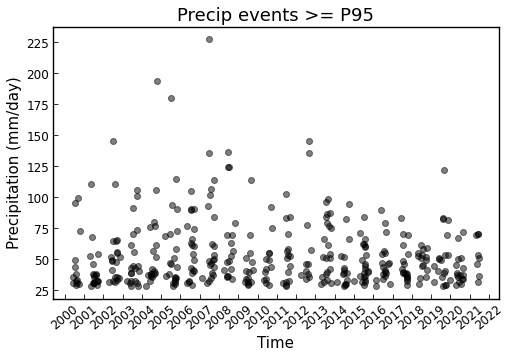

In [32]:
plt.figure(figsize=(8,5))
y = precip_ex
time = precipCal_one_grid.coords['time']
plt.scatter(time.to_numpy(),y, color='k', alpha=0.5)
plt.ylabel('Precipitation (mm/day)')
plt.xlabel('Time')
plt.title('Precip events >= P95')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))   #to get a tick every 15 minutes
plt.xticks(fontsize = 12, rotation=40)
plt.yticks(fontsize = 12)

In [56]:
betaarr = np.empty((20))
freqarr = np.empty((20))
intarr = np.empty((20))
beta_tot = 0
freq = 0
for i in range(0,20):
    yr_events = list(precip_ex.groupby(precip_ex.coords['time.year']))[i][1]
    for event in yr_events:
        if event > precip_clim1[i]:
            beta = (event - precip_clim3[i])
            beta_tot = beta_tot + beta
            freq = freq + 1
    betaarr[i] = (beta_tot)
    freqarr[i] = freq
    intarr[i] = (beta_tot)/freq
    beta_tot = 0
    freq = 0
    print(f"Completed year {i}", end='\r')

In [57]:
def grouped_sum(a, n=5) :
    groups = int(len(a)/n)
    out = np.empty((groups))
    for group in range(groups):
        out[group] = np.sum(a[group*n:n*group+n])
    return out

In [58]:
freqarr

array([13., 19., 20., 21., 19., 22., 20., 22., 17., 15., 13., 16., 11.,
       22., 16., 23., 19., 18., 15., 19.])

In [59]:
grouped_sum(freqarr, n = 3)

array([52., 62., 59., 44., 49., 60.])

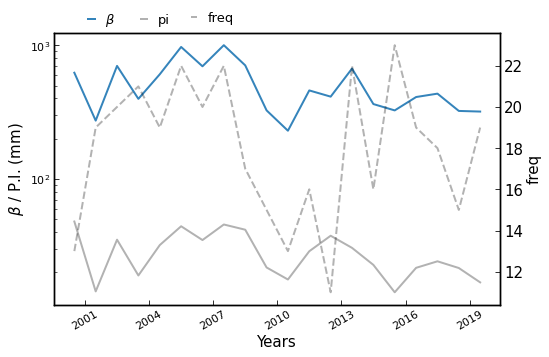

In [60]:
fig, ax = plt.subplots(figsize=(8,5))
axt = ax.twinx()
ax.semilogy(pd.date_range("2000","2020", freq='A-JUN'), betaarr, color='tab:blue', alpha = 0.9, ls = '-', lw=2.0, label=r'$\beta$')
# ax.plot(pd.date_range("2000","2020", freq='4Y'), grouped_sum(betaarr, n = 4), color='tab:blue', alpha = 0.9, ls = '-', lw=2.0, label=r'$\beta$')
axt.plot(pd.date_range("2000","2020", freq='A-JUN'), freqarr, color='k', alpha = 0.3, ls = '--', lw=2.0, label = 'freq')
# axt.plot(pd.date_range("2000","2020", freq='4Y'), grouped_sum(freqarr, n = 4), color='k', alpha = 0.3, ls = '--', lw=2.0, label = 'freq')
ax.semilogy(pd.date_range("2000","2020", freq='A-JUN'), intarr, color='k', alpha = 0.3, ls = '-', lw=2.0, label='pi')
# ax.plot(pd.date_range("2000","2020", freq='4Y'), grouped_sum(intarr, n=4), color='k', alpha = 0.3, ls = '-', lw=2.0, label='pi')
ax.set_ylabel(r'$\beta$ / P.I. (mm)')
ax.set_xlabel('Years')
axt.set_ylabel('freq')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))   #to get a tick every 15 minutes
ax.tick_params(axis='x', labelrotation=30, labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.legend(frameon = False, ncol=2, loc='upper left', bbox_to_anchor=[0.05, 1.12], fontsize=13)
axt.legend(frameon = False, ncol=1, loc='upper left', bbox_to_anchor=[0.28, 1.12], fontsize=13)
plt.savefig('./images/monsoon/beta_pi_mum.pdf', dpi=300)

In [61]:
slope, tau, p = mkres(betaarr)
slope, p

(-15.516622141787881, 0.07435290536856365)

## 3-D analysis

In [39]:
import pymannkendall as mk

In [40]:
def mkres(arr):
    res = mk.original_test(arr, alpha=0.05)
    return res.slope, res.Tau, res.p

def seasonal_mkres(arr):
    res = mk.seasonal_test(arr, alpha=0.05, period=12)
    return res.slope, res.Tau, res.p

In [62]:
def get_res(x, y):
    # if np.isnan(np.sum(y)):
    #     slope, intercept, r, p, se = stats.linregress(x, y)
    # else:
    slope, _, _, p, _ = stats.linregress(x, y)
    return slope, p

In [74]:
precip_clim2

<xarray.DataArray 'RAINFALL' (year: 20, LATITUDE: 129, LONGITUDE: 135)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
    quantile   float64 0.95
  * year       (year) int64 1941 1942 1943 1944 1945 ... 1957 1958 1959 1960

In [120]:
def get_trend_pi(precipda):
    xrange = len(precipda[0])
    yrange = len(precipda[0][0])

    beta_ind = np.empty((20,xrange, yrange))
    freq_ind = np.empty((20, xrange, yrange))
    int_ind = np.empty((20, xrange, yrange))

    slope_beta = np.empty((xrange, yrange))
    tau_beta = np.empty((xrange, yrange))
    p_beta = np.empty((xrange, yrange))

    slope_freq = np.empty((xrange, yrange))
    tau_freq = np.empty((xrange, yrange))
    p_freq = np.empty((xrange, yrange))

    slope_int = np.empty((xrange, yrange))
    tau_int = np.empty((xrange, yrange))
    p_int = np.empty((xrange, yrange))

    freq = 0
    beta_tot = 0
    
    for lat in range(xrange):
        for lon in range(yrange):
            precipda_one_grid = precipda.isel(lat = lat, lon = lon)
            p95 = precipda_one_grid.quantile(0.95, interpolation='higher')
            precip_ex = precipda_one_grid.where(precipda_one_grid >= p95)
            for time in range(0,20):
                yr_events = list(precip_ex.groupby(precip_ex.coords['time.year']))[time][1]
                ref_ex = list(precip_clim2_loaded.isel(LATITUDE = lat, LONGITUDE = lon).groupby('TIME.year'))[time][1].quantile(0.95, interpolation='higher')
                for event in yr_events:
                    if event > ref_ex:
                        beta = (event - ref_ex)
                        beta_tot = beta_tot + beta
                        freq = freq + 1
                        beta_ind[time, lat, lon] = (beta_tot)
                        freq_ind[time, lat, lon] = freq
                        int_ind[time, lat, lon] = (beta_tot / freq)
                beta_tot = 0
                freq = 0
            
            slope_beta[lat, lon], tau_beta[lat, lon], p_beta[lat, lon] = mkres(beta_ind[:, lat, lon])
            slope_freq[lat, lon], tau_freq[lat, lon], p_freq[lat, lon] = mkres(freq_ind[:, lat, lon])
            slope_int[lat, lon], tau_int[lat, lon], p_int[lat, lon] = mkres(int_ind[:, lat, lon])
                
            print(f"Completed lat {lat + 1}/{xrange} and lon {lon + 1}/{yrange}", end='\r')
    res_dict = {
        # return slopes
        "slope_beta" : slope_beta,
        "slope_freq" : slope_freq,
        "slope_int" : slope_int,
        # return p-values
        "p_beta" : p_beta,
        "p_freq" : p_freq,
        "p_int" : p_int,
        # return tau-values
        "tau_beta" : tau_beta,
        "tau_freq" : tau_freq,
        "tau_int" : tau_int,
        # return the actual arrays
        "beta_ind" : beta_ind,
        "freq_ind" : freq_ind,
        "int_ind" : int_ind
    }
    return res_dict

In [ ]:
res = get_trend_pi(ds_comb.precipCal.sel(lat = slice(6.5,38.5), lon=slice(66.5, 100)))

In [329]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.feature as cfeature

In [330]:
#### getting the file to plot for boundaries
fname = './shapefiles3/india-composite.shp'
fname_states = './shapefiles2/India_States.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(), facecolor='none')
shape_feature_states = ShapelyFeature(Reader(fname_states).geometries(), ccrs.PlateCarree(), facecolor='none')

In [408]:
lats, lons = np.meshgrid(precipCal.coords['lat'], precipCal.coords['lon'])

In [409]:
# Extent_lists
ind = [59.9, 100.1, -0.1, 40.1]
wcwg = [71.9, 77.1, 8.9, 18.1]

In [248]:
def plot_3d(slope_da, p_da, extent_list, threshold_sig=0.05, marker_size=0.1, freq=1, alpha_stipple=0.3, states=False, **kwargs):
    """
    Function to plot the output of binning 3d function
    -----
    inputs are -
    slope_da : datarray containing slope
    p_da : datarray containing R^2 values for goodness of fit
    title : The title of the output plot
    extent_list : [59.9, 100.1, -0.1, 40.1]
    """
    # choosing the shapefeature to add in the plot
    if states == False:
        ind_coastline = shape_feature
    else:
        ind_coastline = shape_feature_states

    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent_list, crs=ccrs.PlateCarree())
    cf = ax.contourf(lons, lats, slope_da, **kwargs)
    plt.colorbar(cf)
    # (100*(np.exp(slope_da) - 1)).plot.pcolormesh(ax = ax, cbar_kwargs={"label":"C-C scale"}, **kwargs)
    # x, y = np.meshgrid(slope_da.coords['lon'], slope_da.coords['lat'])
    plt.scatter(lons[(np.abs(p_da) < threshold_sig)][::freq],lats[(np.abs(p_da) < threshold_sig)][::freq], marker='o', color = 'k', s=marker_size, alpha=alpha_stipple)
    gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.05, linestyle='--')
    # ax.coastlines(alpha=0.7)
    # ax.add_feature(cfeature.BORDERS, alpha=1.0, lw=0.2)
    ax.add_feature(ind_coastline, alpha=0.7, lw=0.5)
    ax.add_feature(cfeature.COASTLINE, alpha=1.0, lw=0.5)
    gridliner.top_labels = False
    gridliner.right_labels = False
    gridliner.ylines = False
    gridliner.xlines = False

In [249]:
plt.figure(figsize=(6,6))
plot_3d(np.transpose(res['slope_pi']), np.transpose(res['p_pi']), ind, marker_size=0.7, alpha_stipple=0.3, cmap=tmap, levels = np.arange(-0.4, 0.4, 0.05))

NameError: name 'res' is not defined

<Figure size 432x432 with 0 Axes>

## Dyn and Thermo 1-D

In [27]:
# # finding precipitation extremes

# temporary_precip_indx = []

# precip95 = p1.where(p1 > 0.1).quantile(0.95)
# for time in range(len(p1)):
#     if p1[time] > precip95:
#         temporary_precip_indx.append(time)

In [28]:
# np.array(temporary_precip_indx)

In [29]:
# p1 = precip.sel(time = "2000-06-02 01:00:00")
# w1 = w.sel(time = "2000-06-02 01:00:00")
# t1 = t.sel(time = "2000-06-02 01:00:00")
# q1 = q.sel(time = "2000-06-02 01:00:00")

In [27]:
def get_qs(temp, pres):
    """
    Elemental Function to determine the precipitation estimate for each value of tempreature and omega at each grid point. (func to be used in starmap multithreading)
    ------------------
    Input :
        temp : temperature value at a grid point.
        omega_da : vertical velocity value at a grid point
    Output :
        qs : qs value at that grid point
    ------------------
    """
    a1 = 6.1114
    temp0 = 273.16
    a3w = 17.269
    a4w = 35.86
    a3i = 21.875
    a4i = 7.66

    # calculating saturation vapor pressure using temperature values
    if temp > temp0:
        a3 = a3w
        a4 = a4w
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    elif temp < temp0 - 23:
        a3 = a3i
        a4 = a4i
        es = a1 * np.exp(a3 * ((temp - temp0)/(temp - a4)))
    else:
        esw = a1 * np.exp(a3w * ((temp - temp0)/(temp - a4w)))
        esi = a1 * np.exp(a3i * ((temp - temp0)/(temp - a4i)))
        es = esi + ((esw - esi)*(((temp - (temp0 - 23))/23)**2))

    # get saturation specific humidity value
    epsilon = 0.622
    qs = (epsilon * es) / (pres - ((1 - epsilon)*es))
    return qs

In [28]:
def calc_qs(temp, pres):
    pres_range = len(pres)
    qs = np.empty((pres_range))
    for j in range(pres_range):
        qs[j] = get_qs(temp[j], pres[j])
    return qs

# def calc_qs(temp, pres):
#     time_range = len(temp)
#     pres_range = len(pres)
#     qs = np.empty((time_range, pres_range))
#     for i in range(time_range):
#         for j in range(pres_range):
#             qs[i, j] = get_qs(temp[i, j], pres[j])
#     return qs

In [29]:
# t1 = t1.load()
# pres = pres.load()
# w1 = w1.load()
# p1 = p1.load()
# # q1 = q1.load()

In [31]:
# qs = calc_qs(t1.sel(lat=19, lon=72), pres)
qs = calc_qs(t1.sel(time="2015-06-05 00:00:00"), pres)

In [32]:
qs

array([5.82324467e-05, 4.34064764e-06, 4.17202854e-06, 8.14740457e-06,
       1.73749080e-05, 4.68736605e-05, 1.09376155e-04, 2.09214348e-04,
       3.76183444e-04, 8.65922603e-04, 1.83019599e-03, 2.94397460e-03,
       3.96997561e-03, 4.70241750e-03, 5.64178978e-03, 6.68422030e-03,
       8.99867356e-03, 1.18085549e-02, 1.43442645e-02, 1.61603259e-02,
       1.69840112e-02, 1.76680162e-02, 1.77420609e-02, 1.69452693e-02,
       1.75337006e-02, 1.87845177e-02, 2.00062379e-02, 2.15982437e-02,
       2.39082193e-02])

In [33]:
from scipy import integrate

In [34]:
# vert integral function (Simpson's method)
def vert_integ(x, y):
    int = integrate.simpson(y, x, even='avg')

    return int

# finite differnce methods to find derivative
def centered_diff(arr):
    arr_diff = np.empty(len(arr) - 2)
    for i in range((len(arr) - 2)):
        arr_diff[i] = arr[i+2] - arr[i]
    return arr_diff

def forward_diff(arr):
    arr_diff = np.diff(arr)
    return arr_diff

def backward_diff(arr):
    arr_diff = -(np.diff(arr[::-1])[::-1])
    return arr_diff

In [35]:
def rolling(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]

def movmean(a, n=2) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [36]:
p_cdiff = centered_diff(pres)
p_fdiff = forward_diff(pres)
p_bdiff = backward_diff(pres)
#
qs_cdiff = centered_diff(qs)/(p_cdiff)
qs_fdiff = forward_diff(qs)/(p_fdiff)
qs_bdiff = backward_diff(qs)/(p_bdiff)

qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
qs_diff = np.append(qs_diff, qs_bdiff[-1])
# p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
# p_diff = np.append(p_diff, p_bdiff[-1])

pe = (+1/(9.806)) * vert_integ(pres, w1.sel(time="2015-06-05 00:00:00")*qs_diff)
pw = (1/(1000*9.806)) * vert_integ(pres, q1.sel(time = "2015-06-05 00:00:00"))

# p_cdiff = centered_diff(pres)
# p_fdiff = forward_diff(pres)
# p_bdiff = backward_diff(pres)
# #
# pe = np.empty(len(temporary_precip_indx))
# i = 0
# for t in temporary_precip_indx:
#     qs_cdiff = centered_diff(qs[t])/(p_cdiff)
#     qs_fdiff = forward_diff(qs[t])/(p_fdiff)
#     qs_bdiff = backward_diff(qs[t])/(p_bdiff)

#     qs_diff = np.insert(qs_cdiff, 0, qs_fdiff[0])
#     qs_diff = np.append(qs_diff, qs_bdiff[-1])
#     # p_diff = np.insert(p_cdiff, 0, p_fdiff[0])
#     # p_diff = np.append(p_diff, p_bdiff[-1])

#     pe[i] = (-100/9.806) * vert_integ(pres, (w1[t]*qs_diff))
#     i = i +1
# print("Done")

In [41]:
p1.sel(time="2015-06-15 09:00:00")

<xarray.DataArray 'precipCal' ()>
array(17.076315, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-06-15T09:00:00
    lon      float64 72.0
    lat      float64 19.0

In [39]:
print(pe*3600)
print(pw*3600)

0.5390232677954933
1.5276050997254815


In [47]:
p_era = xr.open_dataset('/home/nkv/Downloads/test3.nc')

In [48]:
p_era

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 161, time: 720)
Coordinates:
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 40.0 39.75 39.5 39.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2000-06-30T23:00:00
Data variables:
    mtpr       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-04 14:22:43 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [53]:
p_era.mtpr.sel(latitude = 19, longitude = 72, time = "2000-06-06 03:00:00")

<xarray.DataArray 'mtpr' ()>
array(0.000179, dtype=float32)
Coordinates:
    longitude  float32 72.0
    latitude   float32 19.0
    time       datetime64[ns] 2000-06-06T03:00:00
Attributes:
    units:      kg m**-2 s**-1
    long_name:  Mean total precipitation rate

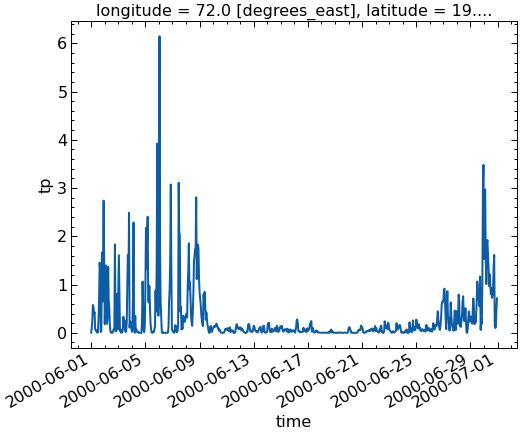

In [129]:
(p_era.tp.sel(latitude = 19, longitude = 72, time="2000-06")*1000).plot()

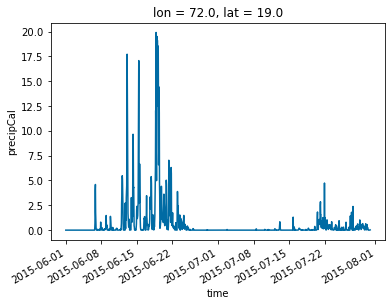

In [42]:
p1.plot()

In [43]:
# t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
# d2m = d2m.chunk(dict(time=5000, lat=40, lon=40))

In [44]:
# ds_comb = xr.merge([precip, t2m, d2m])

In [45]:
# ds_comb